#Start by import!

In [ ]:
import pandas as pd
import numpy as np
from mtcnn import MTCNN
from PIL import Image
import matplotlib.pyplot as plt
import os
import tensorflow as tf


# Initialize the MTCNN face detector
detector = MTCNN()

In [ ]:
!pip install mtcnn
!pip install Pillow
!pip install matplotlib


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 18.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 38.6 MB/s eta 0:00:00


#Connect Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Set Paths

In [ ]:
# Set paths for source and destination folders
source_smile = '/content/drive/MyDrive/genki4k/smile'
source_nonsmile = '/content/drive/MyDrive/genki4k/nonsmile'
dest_smile = '/content/drive/MyDrive/genki4k/f-smile'
dest_nonsmile = '/content/drive/MyDrive/genki4k/f-nonsmile'

# Create destination folders if they don't exist
os.makedirs(dest_smile, exist_ok=True)
os.makedirs(dest_nonsmile, exist_ok=True)

#Face Detection by MTCNN

In [ ]:
def detect_and_crop_faces(source_folder, dest_folder):
    # Loop through each image in the source folder
    for image_name in os.listdir(source_folder):
        image_path = os.path.join(source_folder, image_name)

        # Open the image and convert it to RGB
        image = Image.open(image_path).convert('RGB')
        image_array = np.array(image)

        # Detect faces in the image
        faces = detector.detect_faces(image_array)

        # If at least one face is detected, crop and save the first detected face
        if faces:
            x, y, width, height = faces[0]['box']
            cropped_face = image.crop((x, y, x + width, y + height))

            # Save the cropped face in the destination folder
            cropped_image_path = os.path.join(dest_folder, image_name)
            cropped_face.save(cropped_image_path)
            print(f"Processed and saved: {cropped_image_path}")
        else:
            print(f"No face detected in: {image_name}")


In [ ]:
# Run the function on both folders
detect_and_crop_faces(source_smile, dest_smile)
detect_and_crop_faces(source_nonsmile, dest_nonsmile)

Processed and saved: /content/drive/MyDrive/genki4k/f-smile/file1147.jpg
Processed and saved: /content/drive/MyDrive/genki4k/f-smile/file1140.jpg
Processed and saved: /content/drive/MyDrive/genki4k/f-smile/file1162.jpg
Processed and saved: /content/drive/MyDrive/genki4k/f-smile/file1160.jpg
Processed and saved: /content/drive/MyDrive/genki4k/f-smile/file1170.jpg
Processed and saved: /content/drive/MyDrive/genki4k/f-smile/file1115.jpg
Processed and saved: /content/drive/MyDrive/genki4k/f-smile/file1106.jpg
Processed and saved: /content/drive/MyDrive/genki4k/f-smile/file1126.jpg
Processed and saved: /content/drive/MyDrive/genki4k/f-smile/file1200.jpg
Processed and saved: /content/drive/MyDrive/genki4k/f-smile/file1232.jpg
Processed and saved: /content/drive/MyDrive/genki4k/f-smile/file1249.jpg
Processed and saved: /content/drive/MyDrive/genki4k/f-smile/file1215.jpg
Processed and saved: /content/drive/MyDrive/genki4k/f-smile/file1207.jpg
Processed and saved: /content/drive/MyDrive/genki4k

#Split Data train and validation

In [ ]:
import os
import shutil
import random

source_smile = '/content/drive/MyDrive/genki4k/f-smile'
source_nonsmile = '/content/drive/MyDrive/genki4k/f-nonsmile'
train_smile = '/content/drive/MyDrive/genki4k/faces_train/smile'
val_smile = '/content/drive/MyDrive/genki4k/faces_val/smile'
train_nonsmile = '/content/drive/MyDrive/genki4k/faces_train/nonsmile'
val_nonsmile = '/content/drive/MyDrive/genki4k/faces_val/nonsmile'


# Function to split data
def split_data(source_dir, train_dir, val_dir, split_ratio=0.8):
    files = os.listdir(source_dir)
    random.shuffle(files)
    train_size = int(len(files) * split_ratio)

    for i, file_name in enumerate(files):
        source_file = os.path.join(source_dir, file_name)
        if i < train_size:
            shutil.copy(source_file, train_dir)
        else:
            shutil.copy(source_file, val_dir)

In [ ]:
# Split the data
split_data(source_smile, train_smile, val_smile)
split_data(source_nonsmile, train_nonsmile, val_nonsmile)

#PreProcessing

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the paths for the training data
train_dir = '/content/drive/MyDrive/genki4k/faces_train'
val_dir = '/content/drive/MyDrive/genki4k/faces_val'

# Create ImageDataGenerator instances for training and validation
train_datagen = ImageDataGenerator(rescale=1.0/255, rotation_range=20, width_shift_range=0.2,
                                   height_shift_range=0.2, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)

val_datagen = ImageDataGenerator(rescale=1.0/255)

# Load the data with generators
train_generator = train_datagen.flow_from_directory(train_dir, target_size=(224, 224), batch_size=32, class_mode='binary')
val_generator = val_datagen.flow_from_directory(val_dir, target_size=(224, 224), batch_size=32, class_mode='binary')

Found 3211 images belonging to 2 classes.
Found 804 images belonging to 2 classes.


#Model (Main Part!)

In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam


# Load MobileNetV3Large with pre-trained ImageNet weights, excluding the top layer
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))


x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1, activation='sigmoid')(x)
# Build the model
# model = Sequential([
#     base_model,
#     GlobalAveragePooling2D(),
#     Dense(1, activation='sigmoid')  # Output layer for binary classification
# ])

model = Model(inputs = base_model.input, outputs=x)

#model.summary()

# Freeze the base model layers
base_model.trainable = False

for layer in base_model.layers[-10:]:
  layer.trainable = True

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])


In [ ]:
history = model.fit(train_generator, epochs=18, validation_data=val_generator)

Epoch 1/18
101/101 ━━━━━━━━━━━━━━━━━━━━ 254s 2s/step - accuracy: 0.6302 - loss: 0.6306 - val_accuracy: 0.5398 - val_loss: 1.5245
Epoch 2/18
101/101 ━━━━━━━━━━━━━━━━━━━━ 261s 2s/step - accuracy: 0.7637 - loss: 0.4821 - val_accuracy: 0.6729 - val_loss: 0.6218
Epoch 3/18
101/101 ━━━━━━━━━━━━━━━━━━━━ 251s 2s/step - accuracy: 0.7907 - loss: 0.4357 - val_accuracy: 0.7065 - val_loss: 0.5997
Epoch 4/18
101/101 ━━━━━━━━━━━━━━━━━━━━ 252s 2s/step - accuracy: 0.8094 - loss: 0.4093 - val_accuracy: 0.7948 - val_loss: 0.4366
Epoch 5/18
101/101 ━━━━━━━━━━━━━━━━━━━━ 259s 2s/step - accuracy: 0.8359 - loss: 0.3726 - val_accuracy: 0.8134 - val_loss: 0.3880
Epoch 6/18
101/101 ━━━━━━━━━━━━━━━━━━━━ 253s 2s/step - accuracy: 0.8391 - loss: 0.3728 - val_accuracy: 0.7388 - val_loss: 0.6773
Epoch 7/18
101/101 ━━━━━━━━━━━━━━━━━━━━ 268s 3s/step - accuracy: 0.8465 - loss: 0.3609 - val_accuracy: 0.7562 - val_loss: 0.6050
Epoch 8/18
101/101 ━━━━━━━━━━━━━━━━━━━━ 281s 3s/step - accuracy: 0.8458 - loss: 0.3347 - val_accu

#Visual Result

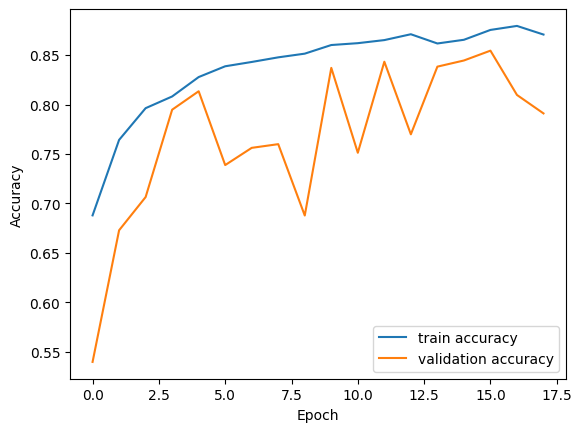

In [ ]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label = 'validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

#Save Model into drive

In [ ]:
model.save('/content/drive/MyDrive/genki4k/mobileNetV2_18ep_10Tlayer.keras')


In [9]:
from tensorflow.keras.models import load_model
model = load_model('/content/drive/MyDrive/genki4k/mobileNetV2_18ep_10Tlayer.keras')
model.save('model.h5')


In [15]:
import tensorflow
print(tensorflow.version)


<module 'tensorflow._api.v2.version' from '/usr/local/lib/python3.10/dist-packages/tensorflow/_api/v2/version/__init__.py'>


#Testing Phase - Video into Frames!

In [16]:
import cv2
import numpy as np
from mtcnn import MTCNN
from tensorflow.keras.models import load_model

# Load your trained model
model = load_model('/content/drive/MyDrive/genki4k/mobileNetV2_18ep_10Tlayer.keras')

# Initialize MTCNN face detector
detector = MTCNN()

# Video input and output settings
input_video_path = '/content/drive/MyDrive/genki4k/mehrazin-test.mp4'  # Path to your video file
output_video_path = '/content/drive/MyDrive/genki4k/output-mehrazin-test.avi'  # Path to save the processed video
cap = cv2.VideoCapture(input_video_path)

# Get video properties
fps = int(cap.get(cv2.CAP_PROP_FPS))
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

# Define video writer
fourcc = cv2.VideoWriter_fourcc(*'XVID')  # Codec
out = cv2.VideoWriter(output_video_path, fourcc, fps, (frame_width, frame_height))

# Process video frame by frame
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Detect faces using MTCNN
    results = detector.detect_faces(frame)

    for result in results:
        # Get bounding box
        x, y, width, height = result['box']
        x, y = max(0, x), max(0, y)  # Ensure coordinates are positive

        # Crop the face
        face = frame[y:y+height, x:x+width]
        face_resized = cv2.resize(face, (224, 224))  # Resize to match model input
        face_preprocessed = np.expand_dims(face_resized, axis=0) / 255.0  # Normalize

        # Predict smile or non-smile
        prediction = model.predict(face_preprocessed)
        label = "Smiling" if prediction[0][0] > 0.5 else "Not Smiling"

        # Draw rectangle and label on the frame
        color = (0, 255, 0) if label == "Smiling" else (0, 0, 255)
        cv2.rectangle(frame, (x, y), (x+width, y+height), color, 2)
        cv2.putText(frame, label, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, color, 2)

    # Write the frame to the output video
    out.write(frame)

    # Optionally, display the frame (for testing)
    # cv2.imshow('Video', frame)
    # if cv2.waitKey(1) & 0xFF == ord('q'):
    #     break

# Release resources
cap.release()
out.release()
cv2.destroyAllWindows()


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━